In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '167397'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

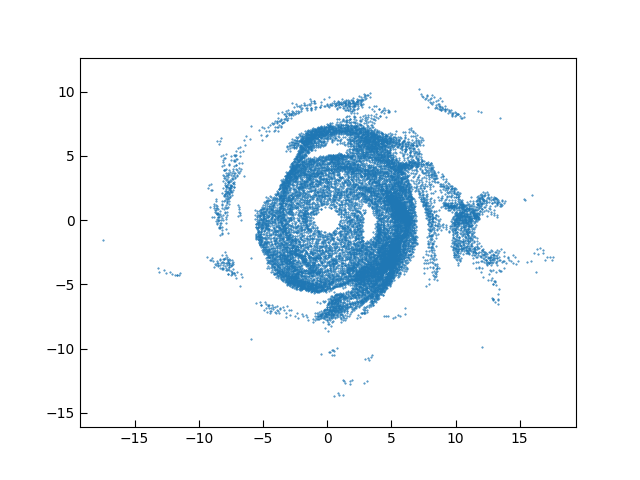

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


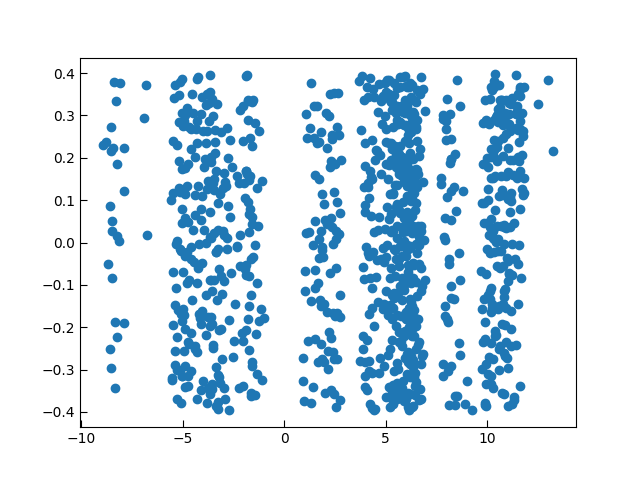

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


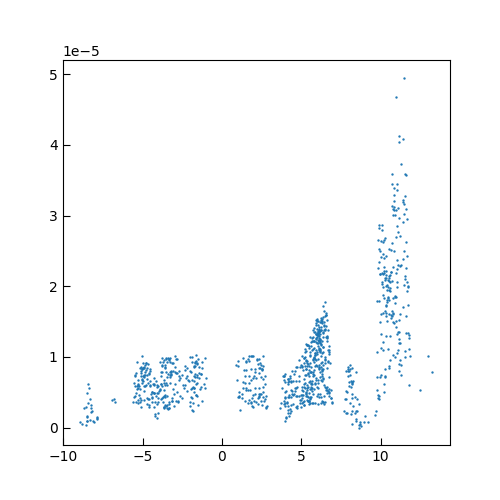

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

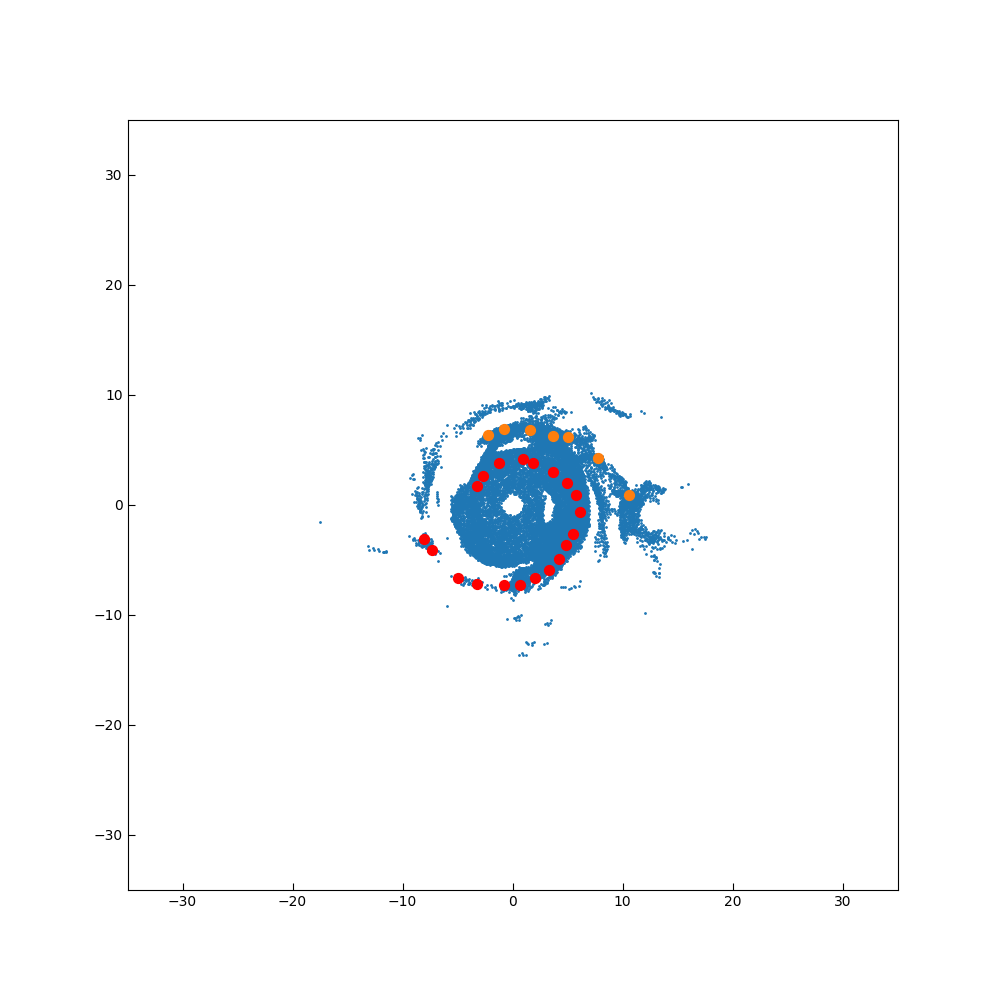

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 35
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [12]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [13]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [14]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [15]:
b = 0.3

In [16]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

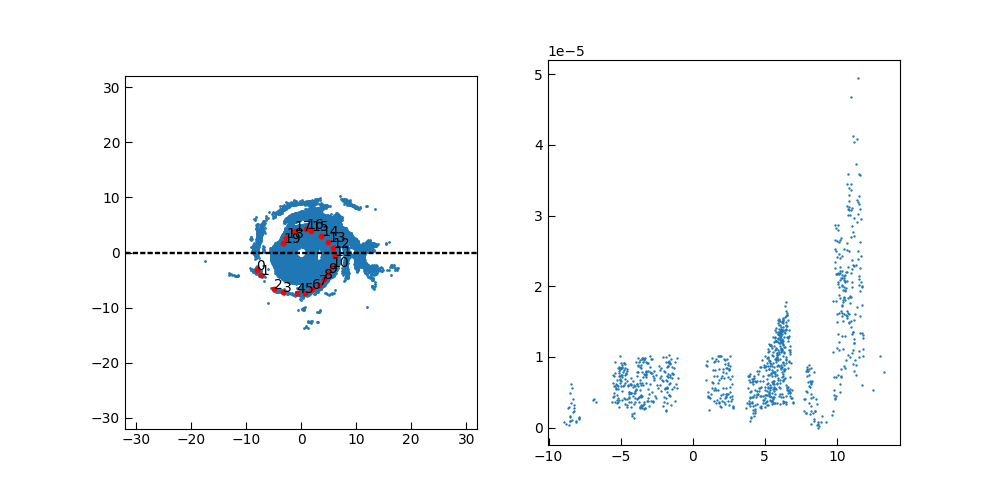

In [17]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 32
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

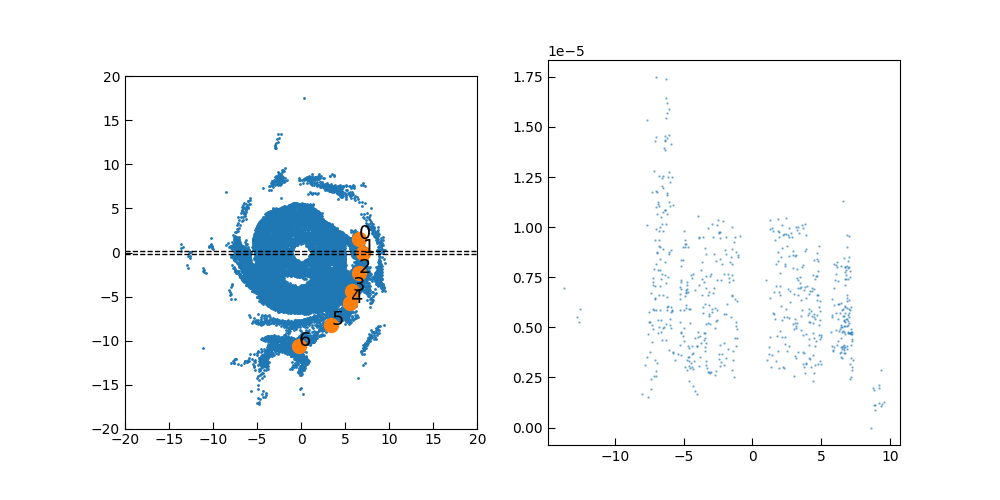

In [36]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 1
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [19]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [20]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [23]:
arm = df_arm2.copy(deep=True)

In [24]:
arm

x         y  arm  id  \
0  -2.258297  6.372655    2   0   
1  -0.757576  6.949856    2   1   
2   1.608947  6.776696    2   2   
3   3.686869  6.257215    2   3   
4   5.072150  6.141775    2   4   
5   7.784993  4.294733    2   5   
6  10.613276  0.889250    2   6   

                                       rotation_info  \
0  ({'x_rot': [0.4672463074098426, 0.561616113080...   
1  ({'x_rot': [0.6541694808213401, 0.746426654165...   
2  ({'x_rot': [0.8632347053725424, 0.943477783989...   
3  ({'x_rot': [0.9649238944813965, 1.026942499224...   
4  ({'x_rot': [0.9842593393612491, 1.034322303517...   
5  ({'x_rot': [0.9319645659496361, 0.949113490604...   
6  ({'x_rot': [0.7202226007816603, 0.697985551021...   

                                     rotation_coords     alpha  \
0  {'x_rot': [0.4672463074098426, 0.5616161130805...  1.911362   
1  {'x_rot': [0.6541694808213401, 0.7464266541659...  1.679374   
2  {'x_rot': [0.8632347053725424, 0.9434777839896...  1.337689   
3  {'x_rot': [0.9649238944813965, 1.0269424992241...  1.038342   
4  {'x_rot': [0.9842593393612491, 1.0343223035173...  0.880494   
5  {'x_rot': [0.9319645659496361, 0.9491134906047...  0.504123   
6  {'x_rot': [0.7202226007816603, 0.6979855510215...  0.083591   

                               All_tracingPoints_rot  \
0  {'x_rot': [6.760964414869783, 6.80374306992578...   
1  {'x_rot': [6.579846584900553, 6.99102390764637...   
2  {'x_rot': [5.678624673765698, 6.58688346788347...   
3  {'x_rot': [4.344024687798856, 5.60316027878066...   
4  {'x_rot': [3.4756421260051518, 4.8763095143448...   
5  {'x_rot': [1.1008846046723593, 2.6937247951647...   
6  {'x_rot': [-1.7183335758622196, -0.17465939822...   

                               This_tracingPoint_rot  \
0  {'x_rot': 6.760964414869783, 'y_rot': 4.440892...   
1  {'x_rot': 6.991023907646376, 'y_rot': 1.332267...   
2  {'x_rot': 6.965077993244294, 'y_rot': -4.44089...   
3         {'x_rot': 7.262626271585889, 'y_rot': 0.0}   
4  {'x_rot': 7.9654318888336775, 'y_rot': 4.44089...   
5  {'x_rot': 8.891054188785022, 'y_rot': -8.88178...   
6  {'x_rot': 10.65046403516093, 'y_rot': -1.11022...   

                                 rotated_arm_profile  
0  {'x_band': [0.9524325908507727, 0.985632373531...  
1  {'x_band': [0.9691956211748038, 1.065751156107...  
2  {'x_band': [1.017471310610592, 1.0103726339696...  
3  {'x_band': [0.9649238944813965, 1.026942499224...  
4  {'x_band': [0.9842593393612491, 1.034322303517...  
5  {'x_band': [1.0257161766851515, 0.963690530747...  
6  {'x_band': [1.1192551361141259, 1.027690112379...

(-2.5, 2.5)

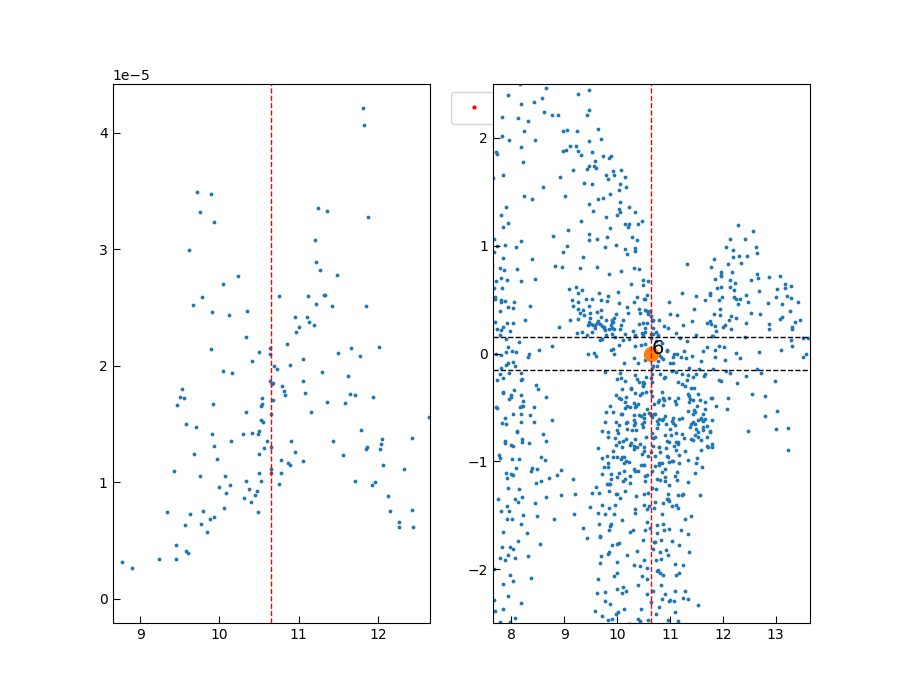

In [86]:
%matplotlib widget

n= 6 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(9,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [87]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [88]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [89]:
n

6

(9.600881403254295e-08, 2.307180882826497e-05)

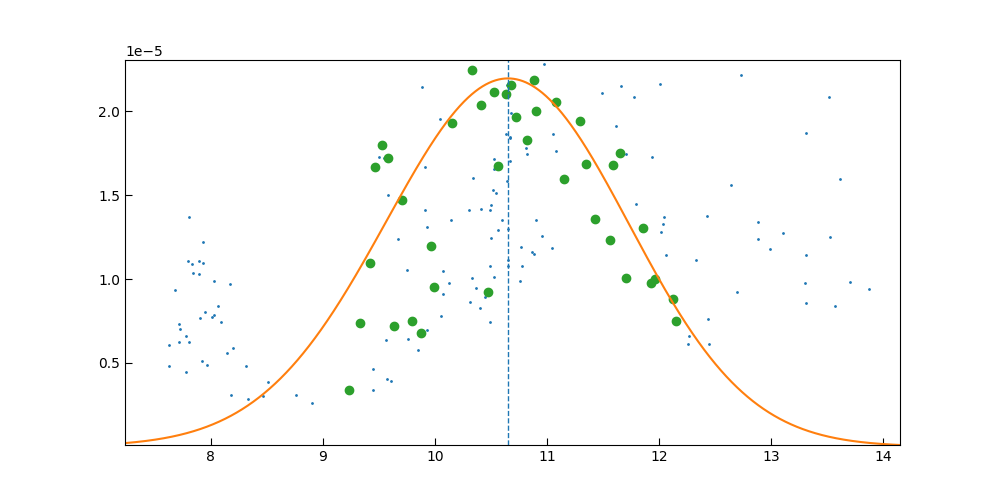

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [91]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [92]:
df_params

amplitude     center  delta fractured      gamma  id_tracing     sigma  \
0   0.000019   5.164766   0.05     False   3.747181         0.0  1.111969   
1   0.000015   7.237613   0.05     False -13.743012         1.0  1.451565   
2   0.000017   7.577721   0.05     False -16.080436         2.0  0.942777   
3   0.000027   7.799011   0.05     False  -7.943289         3.0  1.164565   
4   0.000019   8.289258   0.05     False  -7.824139         4.0  1.333238   
5   0.000060  11.164169   0.05     False  -0.670647         6.0  1.215401   

   stderr_amplitude  stderr_center  stderr_gamma  stderr_sigma  \
0          0.000001       0.050348      1.309773      0.125798   
1          0.000002       0.037721     10.854533      0.238720   
2          0.000001       0.020715      9.391707      0.101432   
3          0.000001       0.021968      1.952438      0.080549   
4          0.000002       0.045445      3.548106      0.178155   
5          0.000005       2.654271      4.267392      1.425113   

                                                   x  x_tracing  \
0  [4.907973004534669, 4.955292068402612, 4.95957...  -2.258297   
1  [5.749240389832841, 5.797541603864896, 5.86108...  -0.757576   
2  [6.025349429404422, 6.07292622726152, 6.141188...   1.608947   
3  [6.008360147112144, 6.106617414195098, 6.15028...   3.686869   
4  [6.4696782244948725, 6.5606068005184905, 6.580...   5.072150   
5  [9.237498595048871, 9.333129193069336, 9.42659...  10.613276   

                                                   y  y_tracing  
0  [2.9682004829876985e-06, 4.664261637555257e-06...   6.372655  
1  [4.784145213890141e-06, 6.427305496566608e-06,...   6.949856  
2  [3.4518138951683857e-06, 4.123771152044607e-06...   6.776696  
3  [3.576889758242131e-06, 7.7763575014456e-06, 9...   6.257215  
4  [4.544098101222789e-06, 5.603830474986577e-06,...   6.141775  
5  [3.3712289156867938e-06, 7.400746081034428e-06...   0.889250

In [93]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [94]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [95]:
arm.iloc[n].id

6

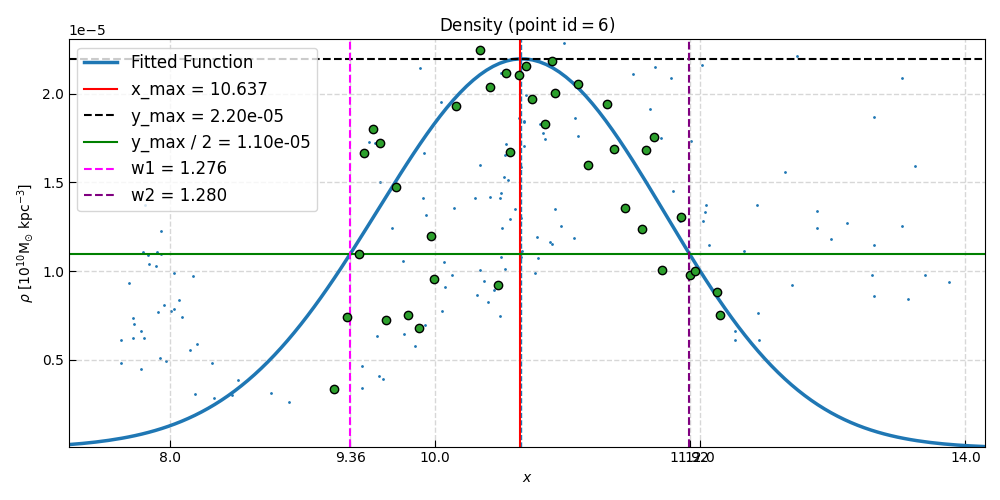

In [96]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

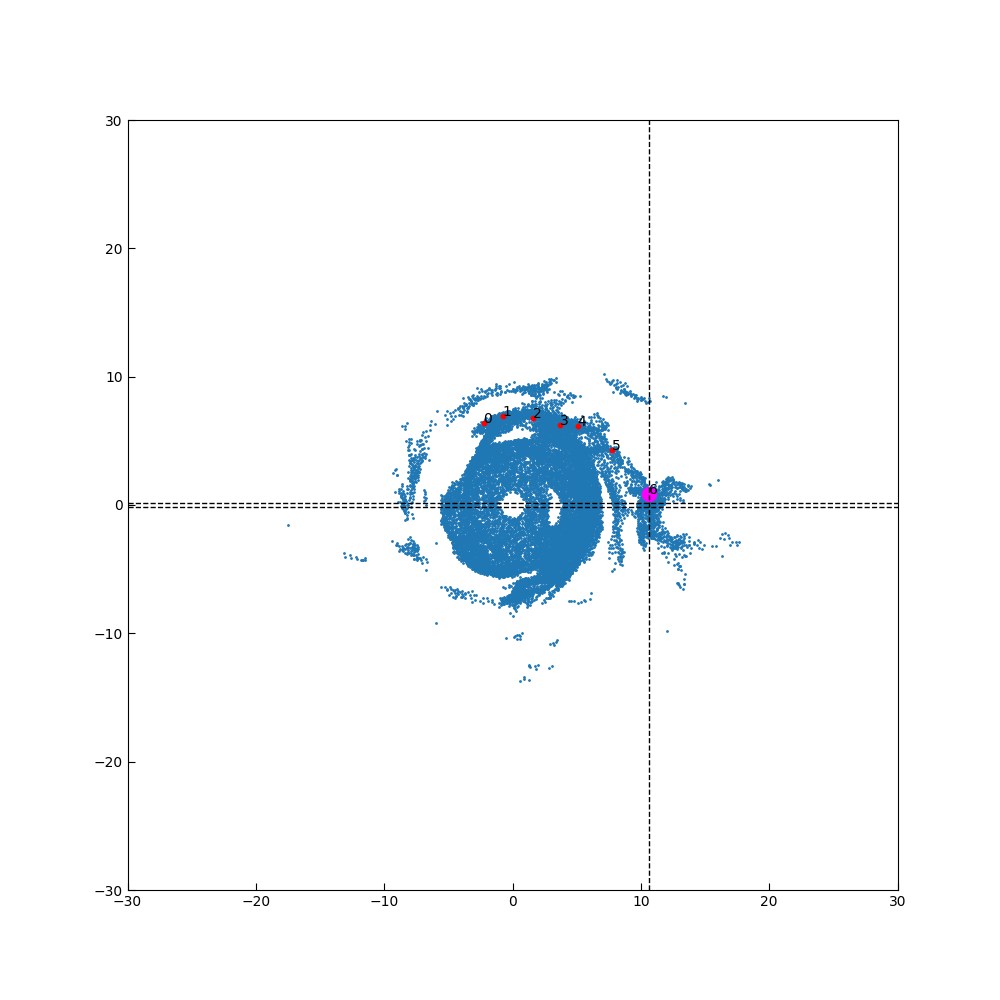

In [97]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 30
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [98]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [99]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

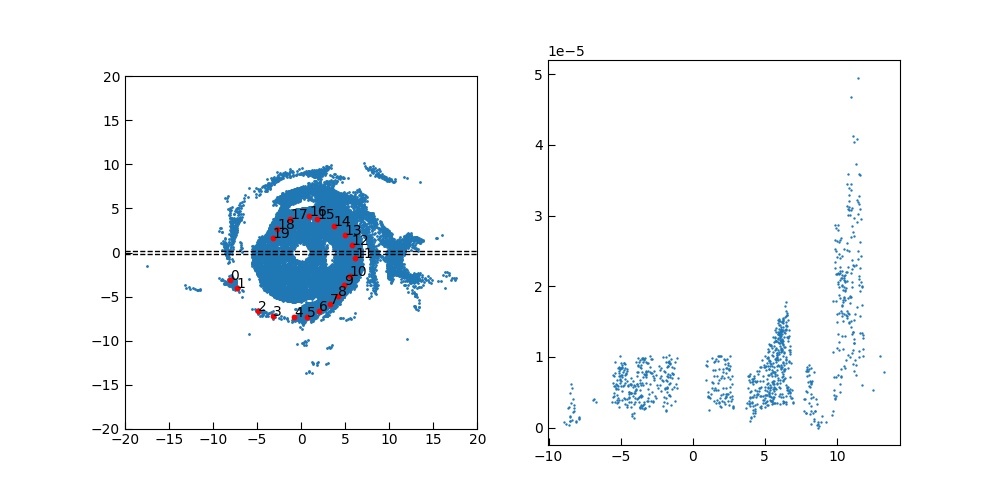

In [100]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [101]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [102]:
arm

x         y  arm  id  \
0  -8.088023 -3.093434    1   0   
1  -7.337662 -4.074675    1   1   
2  -4.913420 -6.672078    1   2   
3  -3.239538 -7.191558    1   3   
4  -0.815296 -7.306999    1   4   
5   0.685426 -7.306999    1   5   
6   2.012987 -6.672078    1   6   
7   3.282828 -5.863997    1   7   
8   4.206349 -4.882756    1   8   
9   4.898990 -3.670635    1   9   
10  5.533911 -2.631674    1  10   
11  6.111111 -0.611472    1  11   
12  5.764791  0.889250    1  12   
13  4.956710  1.985931    1  13   
14  3.686869  2.967172    1  14   
15  1.839827  3.832973    1  15   
16  0.916306  4.179293    1  16   
17 -1.219336  3.832973    1  17   
18 -2.720058  2.678571    1  18   
19 -3.239538  1.697330    1  19   

                                        rotation_info  \
0   ({'x_rot': [-0.878752658339262, -0.88289334343...   
1   ({'x_rot': [-0.9328522993964559, -0.9502598872...   
2   ({'x_rot': [-0.9802334855439928, -1.0346620232...   
3   ({'x_rot': [-0.9374496223679613, -1.0068541334...   
4   ({'x_rot': [-0.7990172629409653, -0.8847117273...   
5   ({'x_rot': [-0.665181550921938, -0.75712827969...   
6   ({'x_rot': [-0.5079475928067186, -0.6022966254...   
7   ({'x_rot': [-0.313946310217442, -0.40665375792...   
8   ({'x_rot': [-0.12140157175658667, -0.208712020...   
9   ({'x_rot': [0.09162179079705413, 0.01406050255...   
10  ({'x_rot': [0.2838737813913432, 0.218485332289...   
11  ({'x_rot': [0.5855855588278888, 0.546999293296...   
12  ({'x_rot': [0.7651499326115758, 0.749332752737...   
13  ({'x_rot': [0.885669401982431, 0.8912962295892...   
14  ({'x_rot': [0.9731787832142135, 1.006096229978...   
15  ({'x_rot': [0.9445369152279013, 1.012367956677...   
16  ({'x_rot': [0.8549013108855142, 0.935990847173...   
17  ({'x_rot': [0.4952473623307331, 0.589625956070...   
18  ({'x_rot': [0.04093737248023138, 0.12501878261...   
19  ({'x_rot': [-0.247140100031554, -0.17916591830...   

                                      rotation_coords     alpha  \
0   {'x_rot': [-0.878752658339262, -0.882893343438...  3.506897   
1   {'x_rot': [-0.9328522993964559, -0.95025988726...  3.648503   
2   {'x_rot': [-0.9802334855439928, -1.03466202328...  4.077639   
3   {'x_rot': [-0.9374496223679613, -1.00685413345...  4.289149   
4   {'x_rot': [-0.7990172629409653, -0.88471172733...  4.601271   
5   {'x_rot': [-0.665181550921938, -0.757128279695...  4.805919   
6   {'x_rot': [-0.5079475928067186, -0.60229662545...  5.005408   
7   {'x_rot': [-0.313946310217442, -0.406653757926...  5.222746   
8   {'x_rot': [-0.12140157175658667, -0.2087120201...  5.423505   
9   {'x_rot': [0.09162179079705413, 0.014060502559...  5.640156   
10  {'x_rot': [0.2838737813913432, 0.2184853322894...  5.839285   
11  {'x_rot': [0.5855855588278888, 0.5469992932965...  6.183458   
12  {'x_rot': [0.7651499326115758, 0.7493327527378...  0.153049   
13  {'x_rot': [0.885669401982431, 0.89129622958924...  0.381071   
14  {'x_rot': [0.9731787832142135, 1.0060962299785...  0.677658   
15  {'x_rot': [0.9445369152279013, 1.0123679566771...  1.123276   
16  {'x_rot': [0.8549013108855142, 0.9359908471739...  1.354962   
17  {'x_rot': [0.4952473623307331, 0.5896259560705...  1.878791   
18  {'x_rot': [0.04093737248023138, 0.125018782619...  2.363879   
19  {'x_rot': [-0.247140100031554, -0.179165918302...  2.658975   

                                All_tracingPoints_rot  \
0   {'x_rot': [8.659414155099267, 8.30909824822909...   
1   {'x_rot': [8.572738499767427, 8.39310833857554...   
2   {'x_rot': [7.286900639524385, 7.63206935059654...   
3   {'x_rot': [6.142363619596583, 6.7288374384215,...   
4   {'x_rot': [3.971231349404361, 4.86321383813298...   
5   {'x_rot': [2.324540794322849, 3.37157218949744...   
6   {'x_rot': [0.6254081937146716, 1.7815618920806...   
7   {'x_rot': [-1.2516715831320298, -0.02892712727...   
8   {'x_rot': [-2.9351940176902613, -1.70202727166...   
9   {'x_rot': [-4.617811914825739, -3.428936687525...   
10  {'x_rot': [-5.975638054501715, -4.8765

(-2.5, 2.5)

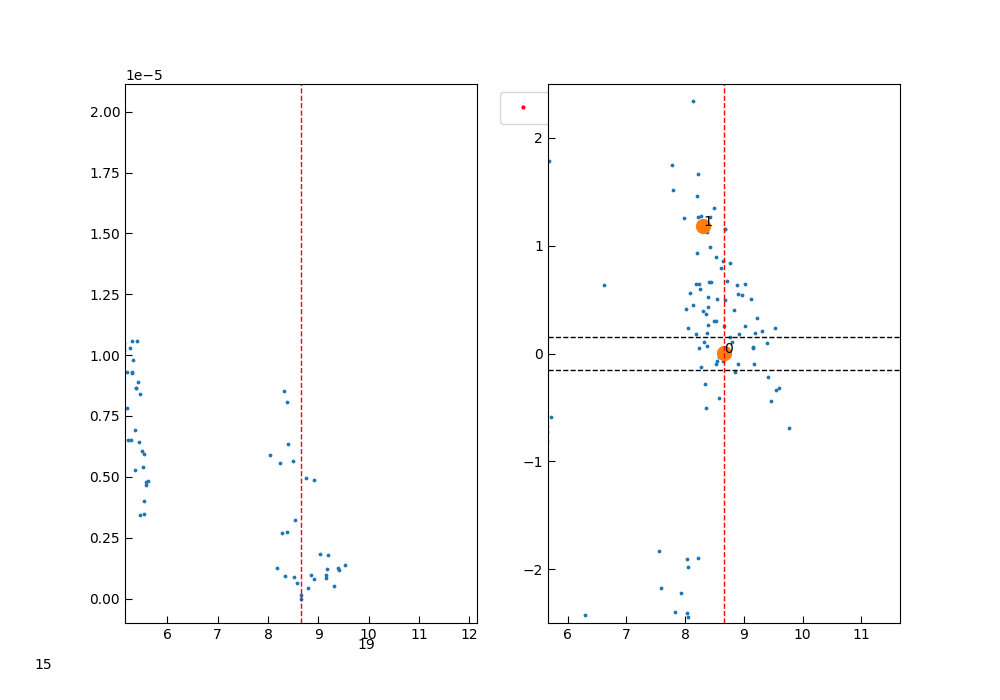

In [263]:
n= 0 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-3.5,x_tracing+3.5)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [264]:
dict_lims = klicker.get_positions()
#print(dict_lims)}

In [265]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  


(-0.05, 0.05)

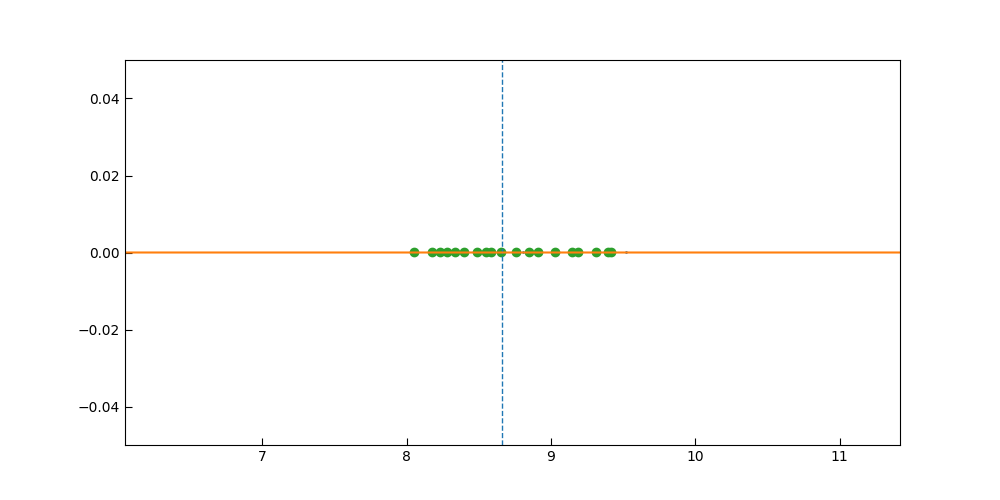

In [266]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [258]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [259]:
df_params

amplitude    center  delta fractured      gamma  id_tracing     sigma  \
0   2.528987e-05  4.327923   0.05     False  -5.542683        19.0  2.118416   
1   3.143181e-05  2.058826   0.05     False   3.599381        18.0  2.835971   
2   3.717184e-05  3.322201   0.05     False   0.008748        17.0  1.893317   
3   2.929565e-05  5.676208   0.05     False  -7.102436        16.0  2.927461   
4   5.526988e-05  6.904048   0.05     False  -8.256414        14.0  4.694633   
5   4.006527e-05  7.070994   0.05     False  -9.703593        13.0  2.297004   
6   3.336505e-05  6.903482   0.05     False -15.927113        12.0  1.833261   
7   3.333397e-05  6.883530   0.05     False  -8.538946        11.0  1.832103   
8   3.644183e-05  6.909247   0.05     False  -8.877121        10.0  2.001538   
9   3.329032e-05  6.823246   0.05     False -10.555221         9.0  1.852628   
10  7.030371e-05  4.367910   0.05     False   6.318632         8.0  5.143101   
11  2.644251e-05  7.400693   0.05     False  -7.009320         7.0  2.061200   
12  1.625998e-05  7.418620   0.05     False  -4.259593         6.0  1.518542   
13  2.346443e-05  5.936334   0.05     False   1.298285         5.0  0.931345   
14  6.277544e-06  7.267759   0.05     False   5.103153         4.0  0.707465   
15  4.953281e-07  8.043259   0.05     False   0.148715         2.0  0.041011   
16  9.598299e-07  8.489065   0.05     False  -1.604037         1.0  0.104251   

   stderr_amplitude stderr_center stderr_gamma stderr_sigma  \
0       1.55146e-06     0.0552483      1.92643     0.207561   
1       6.84948e-06      0.214431      3.57977      1.16742   
2       4.58313e-06       52537.7      34781.5      367.078   
3       2.90956e-06      0.161671      3.61551     0.393781   
4       4.91663e-06     0.0967185      2.98037     0.603306   
5       1.81213e-06      0.047038      2.92916     0.145917   
6       1.24302e-06      0.024843      5.25831    0.0913677   
7       1.12126e-06     0.0316849      2.28878    0.0852453   
8       1.13452e-06     0.0285602      2.02561    0.0883985   
9        1.4963e-06     0.0317715      3.10758     0.117294   
10      6.70039e-05       0.24681       9.6528       5.8995   
11      2.54744e-06     0.0824678      4.27137     0.311119   
12      2.20904e-06      0.128036      3.07344     0.346171   
13      1.61783e-06       0.27381      1.17678     0.279125   
14       6.6269e-06      0.135338      14.8705      1.11744   
15             None          None         None         None   
16      1.39157e-07     0.0429296      2.47961    0.0509392   

                                                    x  x_tracing  \
0   [1.4358880717326277, 1.5425859512920475, 1.681...  -3.239538   
1   [1.7829758618381626, 2.0636857044434738, 2.125...  -2.720058   
2   [1.7321970879913517, 1.8090091310632272, 1.892...  -1.219336   
3   [1.9518302057827281, 2.142228630979257, 2.3258...   0.916306   
4   [1.9807231131918344, 2.0556487762555724, 2.096...   3.686869   
5   [2.990231014457129, 3.287509923578728, 3.33815...   4.956710   
6   [4.005918317478564, 4.074023639829986, 4.12675...   5.764791   
7   [3.7640529519709878, 3.811416668040541, 3.8952...   6.111111   
8   [3.5237255595309187, 3.605689306724326, 3.6732...   5.533911   
9   [3.520085634295892, 3.6466624344498815, 3.7163...   4.898990   
10  [3.6993950191334886, 3.8299269543088323, 3.970...   4.206349   
11  [4.660213010365016, 4.742229706384458, 4.81680...   3.282828   
12  [5.150165098317817, 5.270472543746204, 5.31237...   2.012987   
13  [4.878585583773067, 5.17342491313643, 5.190880...   0.685426   
14  [6.466868643092643, 7.181608020103342, 7.29167...  -0.815296   
15  [8.008311779006753, 8.078275878315909, 8.09479...  -4.913420   
16  [8.084947396947015, 8.259771408649309, 8.33423...  -7.337662   

                                                    y  y_tracing  
0   [4.0695135942115005e-06, 5.175936129375843e-06...   1.697330  
1   [2.5930253641387212e-06, 3.838349901228395e-06...   2.678571  
2   [

In [260]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                  9.5983e-07
center                                                        8.48906
delta                                                            0.05
fractured                                                       False
gamma                                                        -1.60404
id_tracing                                                          1
sigma                                                        0.104251
stderr_amplitude                                          1.39157e-07
stderr_center                                               0.0429296
stderr_gamma                                                  2.47961
stderr_sigma                                                0.0509392
x                   [8.084947396947015, 8.259771408649309, 8.33423...
x_tracing                                                    -7.33766
y                   [1.4290320127449094e-06, 9.617250813219973e-07...
y_tracing           

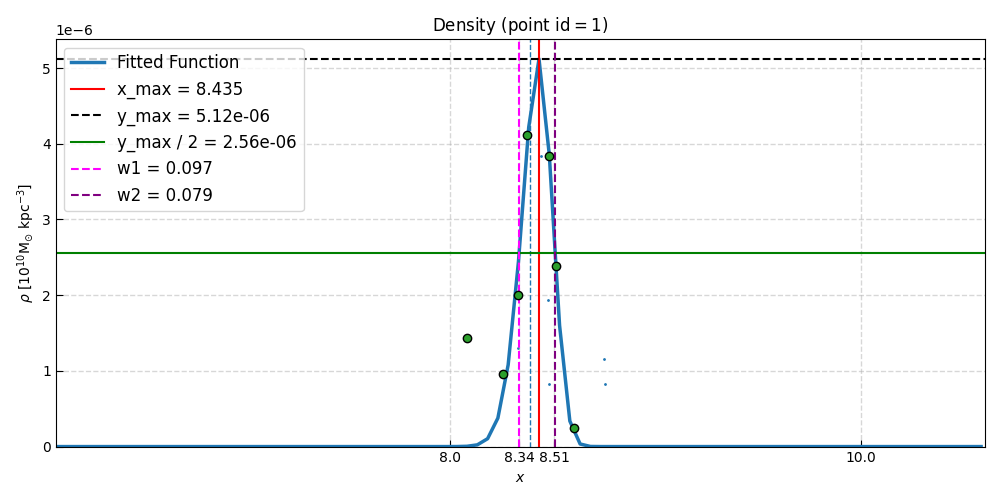

In [261]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

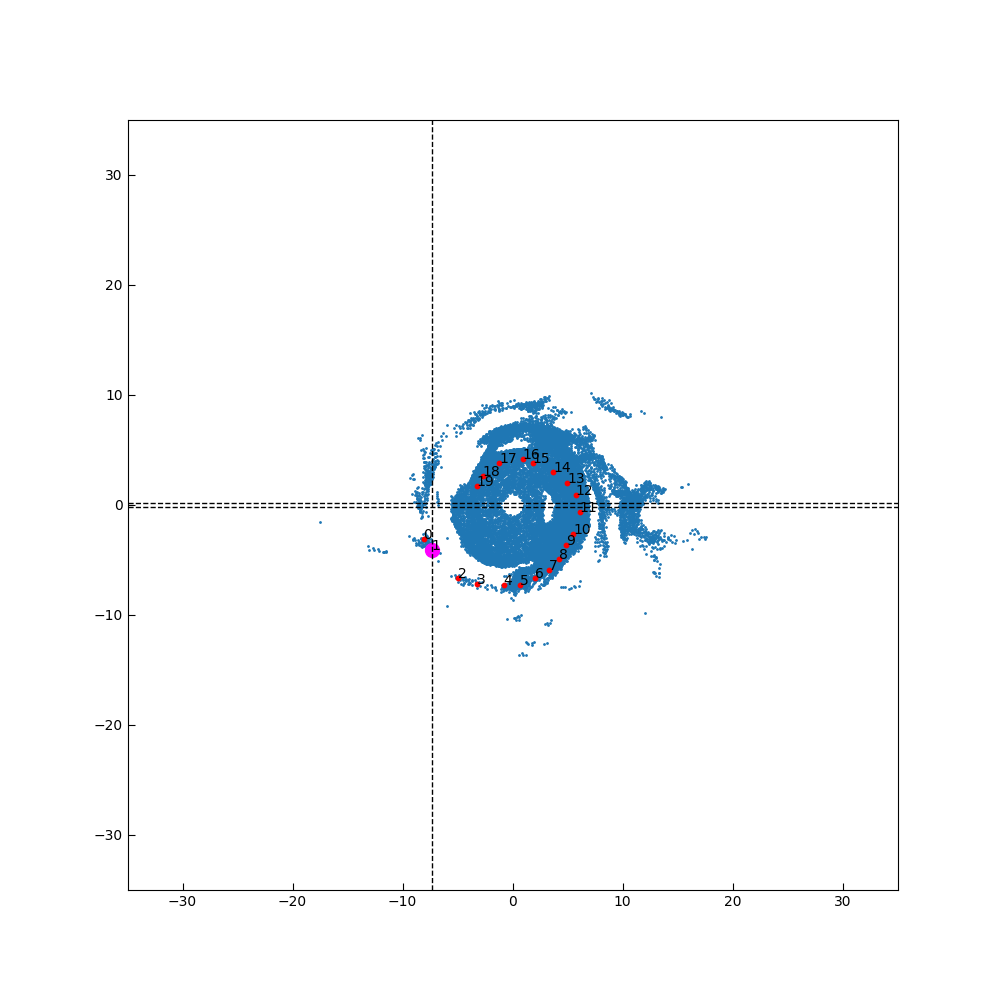

In [262]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 35
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [267]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')